In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\natnj\AppData\Local\Temp\ipykernel_42312\2871419233.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_csv('train_data.csv')
df.head()

,Index,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0,0,0.450397,0.504034,0.506986,0.594640,0.594640,0.998906,0.797293,0.809239,...,0.780554,0.004919,0.623634,0.594641,0.838869,0.279036,0.026788,0.565144,1,0.032464
1,1,0,0.530005,0.572885,0.574763,0.605695,0.605558,0.999058,0.797512,0.809399,...,0.819963,0.005968,0.624171,0.605690,0.841869,0.279040,0.026801,0.565205,1,0.032442
2,2,0,0.571150,0.620148,0.624177,0.612275,0.612282,0.999163,0.797654,0.809533,...,0.839128,0.006022,0.625306,0.612271,0.843294,0.278927,0.026816,0.565276,1,0.033034
3,3,0,0.483401,0.556694,0.536164,0.602445,0.602445,0.999035,0.797458,0.809380,...,0.806477,0.002177,0.621610,0.602444,0.841891,0.293391,0.027063,0.566190,1,0.015406
4,4,0,0.510359,0.537287,0.552546,0.600023,0.600023,0.999009,0.797406,0.809313,...,0.799277,0.001124,0.623993,0.600019,0.840313,0.279878,0.026880,0.565549,1,0.028858


## 1 Training Data Preparation

In [4]:
df = df.drop(['Index'], axis=1)
X = df.drop(['Bankrupt?'], axis=1)
y = df['Bankrupt?']
X.shape # 95 features (must reduce to <= 50)

(5807, 95)

In [5]:
# 2. evaluate whether relationship betweeen each feature and target is non-linear

# spearman's correlation matrix
correlation_matrix = df.corr(method='spearman')
non_linear_features = []
linear_features = []

# using a correlation threshold (rho < 0.95 or rho > -0.95) to distinguish non-linear from linear
for column in correlation_matrix.columns:
    if column != 'Bankrupt?':
        if abs(correlation_matrix.at['Bankrupt?', column]) < 0.95:
            non_linear_features.append(column)
        else:
            linear_features.append(column)

print("Non linear features: ", non_linear_features)
print("Linear features: ", linear_features)

Non linear features:  [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Continuous Net Profi

In [6]:
X = X.drop(linear_features, axis=1) # dropping linear feature

In [7]:
# 3. extract feature if and only if it holds a strong pos or neg correlation between other features

# compute correlation matrix 
correlation_matrix = X.corr(method='spearman').abs()
threshold = 0.95

# identify pairs of highly correlated features
highly_correlated_pairs = {}
for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j and correlation_matrix.at[i, j] >= threshold:
            # add the pair if j has not been added to any pair yet
            if i not in highly_correlated_pairs and j not in highly_correlated_pairs:
                highly_correlated_pairs[i] = j

print("Highly correlated pairs:", highly_correlated_pairs)

# selecting one feature from each pair to drop
features_to_drop = list(highly_correlated_pairs.values())
X_reduced = X.drop(columns=features_to_drop)

print("Number of remaining features:", X_reduced.shape)

Highly correlated pairs: {' ROA(C) before interest and depreciation before interest': ' ROA(B) before interest and depreciation after tax', ' ROA(A) before interest and % after tax': ' Per Share Net profit before tax (Yuan ¥)', ' Operating Gross Margin': ' Realized Sales Gross Margin', ' Realized Sales Gross Margin': ' Gross Profit to Sales', ' Pre-tax net Interest Rate': ' After-tax net Interest Rate', ' After-tax net Interest Rate': ' Continuous interest rate (after tax)', ' Cash flow rate': ' Operating Funds to Liability', ' Net Value Per Share (B)': ' Net Value Per Share (A)', ' Net Value Per Share (A)': ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons': ' Per Share Net profit before tax (Yuan ¥)', ' Cash Flow Per Share': ' CFO to Assets', ' Operating Profit Per Share (Yuan ¥)': ' Operating profit/Paid-in capital', ' Per Share Net profit before tax (Yuan ¥)': ' Net profit before tax/Paid-in capital', ' After-tax Net Profit Growth Rate': ' Regular Net Profit Gro

In [8]:
# 4. confirm normality of each feature
from scipy.stats import shapiro

normality_results = {}

# testing each feature for normality using the shapiro-wilk test
for column in X_reduced.columns:
    stat, p = shapiro(X[column])
    normality_results[column] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}

# convert the results to df for better visualization
normality_results_df = pd.DataFrame.from_dict(normality_results, orient='index')
print(len(normality_results))


65


C:\Users\natnj\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [21]:
# applying PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# applying PCA
pca = PCA(n_components=50)  
X_pca = pca.fit_transform(X_scaled)

# variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = pca.explained_variance_ratio_.cumsum()

print("Explained Variance Ratio per Principal Component: ", explained_variance)
print("Cumulative Explained Variance: ", cumulative_variance)

# checking how many components are enough to retain at least 95% of the total variance
n_components_95 = (cumulative_variance < 0.95).sum() + 1

print("Number of components to retain 95% variance: ", n_components_95)

# create df from PCA results 
X_pca_df = pd.DataFrame(X_pca[:, :n_components_95], columns=[f'PC{i+1}' for i in range(n_components_95)])
print(len(X_pca))
len(X_pca_df)

Explained Variance Ratio per Principal Component:  [0.09593535 0.06211717 0.05204229 0.04526434 0.04013014 0.03092229
 0.03075304 0.02780829 0.02512453 0.02278163 0.0221592  0.02055591
 0.01955183 0.01934565 0.01875659 0.01747266 0.01688697 0.01673147
 0.01636465 0.01607419 0.01589505 0.0156819  0.01553152 0.01537312
 0.01535546 0.01524064 0.01495413 0.014808   0.01460812 0.01441137
 0.01427324 0.01392775 0.01363638 0.01356284 0.01319042 0.0126964
 0.01255708 0.01197137 0.01138402 0.01105942 0.01051376 0.00953252
 0.00858777 0.00806042 0.00770301 0.0070187  0.00668319 0.00617058
 0.00571209 0.00522098]
Cumulative Explained Variance:  [0.09593535 0.15805252 0.21009481 0.25535916 0.29548929 0.32641158
 0.35716462 0.38497291 0.41009744 0.43287907 0.45503827 0.47559418
 0.49514601 0.51449166 0.53324825 0.55072091 0.56760787 0.58433934
 0.60070399 0.61677818 0.63267323 0.64835512 0.66388665 0.67925977
 0.69461523 0.70985587 0.72481    0.73961801 0.75422612 0.7686375
 0.78291074 0.79683849 0

5807

In [ ]:
# successfully reduced number of features to 47

## 2 Company Characterization

In [10]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

k = 5
kmeans = KMeans(n_clusters=k, random_state=42) # kmeans clustering
clusters_kmeans = kmeans.fit_predict(X_pca)

gmm = GaussianMixture(n_components=k, random_state=42) # gaussian mixture model clustering
clusters_gmm = gmm.fit_predict(X_pca)

# add clusters back to the df
df['Cluster_KMeans'] = clusters_kmeans
df['Cluster_GMM'] = clusters_gmm

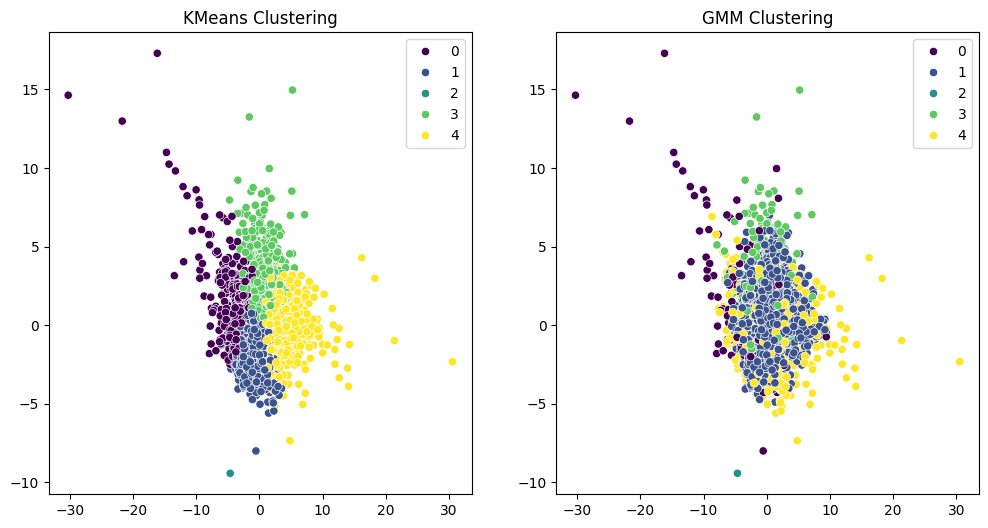

In [11]:
# Visualizing clusters using PCA components
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_kmeans, palette='viridis')
plt.title('KMeans Clustering')
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_gmm, palette='viridis')
plt.title('GMM Clustering')
plt.show()

In [16]:
# Analyzing characteristics by cluster
for c in range(k):
    cluster_data = df[df['Cluster_KMeans'] == c]
    print(f"Cluster {c} characteristics:")
    print(cluster_data.describe()) 


Cluster 0 characteristics:
        Bankrupt?   ROA(C) before interest and depreciation before interest  \
count  642.000000                                         642.000000          
mean     0.168224                                           0.408624          
std      0.374357                                           0.062413          
min      0.000000                                           0.000000          
25%      0.000000                                           0.387510          
50%      0.000000                                           0.423293          
75%      0.000000                                           0.445998          
max      1.000000                                           0.533710          

        ROA(A) before interest and % after tax  \
count                               642.000000   
mean                                  0.446476   
std                                   0.078075   
min                                   0.000000   
25%        

In [20]:
cluster_data.shape

(1220, 98)